In [2]:
from qibolab import QibolabBackend
from qiskit import QuantumRegister
import numpy as np
from gymnasium.spaces import Box
from rl_qoc import QuantumEnvironment, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, Gate
from qiskit.circuit.library import CZGate
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ChannelConfig,
)
from rl_qoc.qibo import QiboConfig
from qiskit import pulse


def param_circuit(
    qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister, **kwargs
):
    cz_cal = Gate("cz_cal", 2, params.params)
    with pulse.build() as cz_sched:
        pulse.play(
            pulse.Gaussian(duration=160, amp=0.5, sigma=40), pulse.DriveChannel(0)
        )
        pulse.play(
            pulse.Gaussian(duration=160, amp=0.5, sigma=40), pulse.DriveChannel(1)
        )
        pulse.shift_phase(np.pi, pulse.DriveChannel(0))
        pulse.shift_phase(np.pi, pulse.DriveChannel(1))
    qc.append(cz_cal, qreg)
    qc.add_calibration(cz_cal, [0, 1], cz_sched)

    return qc


def get_backend():
    return "qibolab"


action_space_low = np.array([0.0, -np.pi, -np.pi, 16])  # [amp, phase, phase, duration]
action_space_high = np.array([1.0, np.pi, np.pi, 160])  # [amp, phase, phase, duration]
action_space = Box(action_space_low, action_space_high)
qibo_config = QiboConfig(
    param_circuit, get_backend(), platform="dummy", qubit_pair=(0, 2), gate_rule="cz"
)
q_env_config = QEnvConfig(
    target={"gate": CZGate(), "physical_qubits": [0, 1]},
    backend_config=qibo_config,
    action_space=action_space,
    reward_config=ChannelConfig(),
    benchmark_config=BenchmarkConfig(0),
    execution_config=ExecutionConfig(batch_size=1, sampling_paulis=50, n_shots=1000),
)

env = QuantumEnvironment(q_env_config)

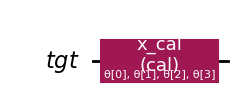

In [3]:
env.circuits[0].draw(output="mpl")

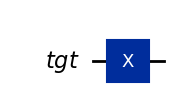

In [4]:
env.baseline_circuits[0].draw(output="mpl")

In [7]:
env.step(np.array([[0.5, 0, 0, 80]]))

[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Loading platform dummy


Sending Estimator job...
2024-11-11 16:44:01 INFO Loading platform dummy


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Using qibolab (dummy) backend on /CPU:0


2024-11-11 16:44:01 INFO Using qibolab (dummy) backend on /CPU:0


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Loading platform dummy


2024-11-11 16:44:01 INFO Loading platform dummy


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Connecting to instrument <qibolab.instruments.dummy.DummyInstrument object at 0x382b91a90>.


2024-11-11 16:44:01 INFO Connecting to instrument <qibolab.instruments.dummy.DummyInstrument object at 0x382b91a90>.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Connecting to dummy instrument.


2024-11-11 16:44:01 INFO Connecting to dummy instrument.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Connecting to instrument <qibolab.instruments.dummy.DummyLocalOscillator object at 0x382b61b90>.


2024-11-11 16:44:01 INFO Connecting to instrument <qibolab.instruments.dummy.DummyLocalOscillator object at 0x382b61b90>.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Minimal execution time (unrolling): 0.02544


2024-11-11 16:44:01 INFO Minimal execution time (unrolling): 0.02544


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Disconnecting dummy instrument.


2024-11-11 16:44:01 INFO Disconnecting dummy instrument.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Loading platform dummy


2024-11-11 16:44:01 INFO Loading platform dummy


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Using qibolab (dummy) backend on /CPU:0


2024-11-11 16:44:01 INFO Using qibolab (dummy) backend on /CPU:0


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Loading platform dummy


2024-11-11 16:44:01 INFO Loading platform dummy


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Connecting to instrument <qibolab.instruments.dummy.DummyInstrument object at 0x37fdf9490>.


2024-11-11 16:44:01 INFO Connecting to instrument <qibolab.instruments.dummy.DummyInstrument object at 0x37fdf9490>.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Connecting to dummy instrument.


2024-11-11 16:44:01 INFO Connecting to dummy instrument.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Connecting to instrument <qibolab.instruments.dummy.DummyLocalOscillator object at 0x3819f7dd0>.


2024-11-11 16:44:01 INFO Connecting to instrument <qibolab.instruments.dummy.DummyLocalOscillator object at 0x3819f7dd0>.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Minimal execution time (unrolling): 0.0218


2024-11-11 16:44:01 INFO Minimal execution time (unrolling): 0.0218


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Disconnecting dummy instrument.


2024-11-11 16:44:01 INFO Disconnecting dummy instrument.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Loading platform dummy


2024-11-11 16:44:01 INFO Loading platform dummy


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Using qibolab (dummy) backend on /CPU:0


2024-11-11 16:44:01 INFO Using qibolab (dummy) backend on /CPU:0


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Loading platform dummy


2024-11-11 16:44:01 INFO Loading platform dummy


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Connecting to instrument <qibolab.instruments.dummy.DummyInstrument object at 0x382bef890>.


2024-11-11 16:44:01 INFO Connecting to instrument <qibolab.instruments.dummy.DummyInstrument object at 0x382bef890>.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Connecting to dummy instrument.


2024-11-11 16:44:01 INFO Connecting to dummy instrument.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Connecting to instrument <qibolab.instruments.dummy.DummyLocalOscillator object at 0x382bef950>.


2024-11-11 16:44:01 INFO Connecting to instrument <qibolab.instruments.dummy.DummyLocalOscillator object at 0x382bef950>.


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Minimal execution time (unrolling): 0.0352


2024-11-11 16:44:01 INFO Minimal execution time (unrolling): 0.0352


[Qibo 0.2.13|INFO|2024-11-11 16:44:01]: Disconnecting dummy instrument.


2024-11-11 16:44:01 INFO Disconnecting dummy instrument.
Time for running 0.05648374557495117
Finished Estimator job


(array([0, 0]),
 array([0.00324484]),
 True,
 False,
 {'step': 1,
  'average return': 0.0032395833333333382,
  'max return': 0.004000000000000009,
  'arg_max return': 0,
  'optimal action': array([0., 0., 0., 0.]),
  'input_state': 'PauliPreparationBasis[0]'})

In [6]:
backend = QibolabBackend(platform="dummy")

[Qibo 0.2.13|INFO|2024-11-11 16:37:36]: Loading platform dummy


2024-11-11 16:37:36 INFO Loading platform dummy


In [8]:
backend.platform

Platform(name='dummy', qubits={0: Qubit(name=0, bare_resonator_frequency=0, readout_frequency=5200000000.0, drive_frequency=4000000000.0, anharmonicity=0, sweetspot=0.0, asymmetry=0.0, crosstalk_matrix={0: 1}, Ec=0.0, Ej=0.0, g=0.0, assignment_fidelity=[0.5, 0.1], readout_fidelity=0.0, gate_fidelity=[0.5, 0.1], effective_temperature=0.0, peak_voltage=0, pi_pulse_amplitude=0, resonator_depletion_time=0, T1=0.0, T2=0.0, T2_spin_echo=0, state0_voltage=0, state1_voltage=0, mean_gnd_states=[0, 1], mean_exc_states=[1, 0], threshold=0.0, iq_angle=0.0, mixer_drive_g=0.0, mixer_drive_phi=0.0, mixer_readout_g=0.0, mixer_readout_phi=0.0, readout=Channel(name='readout', port=DummyPort(name='readout', offset=0.0, lo_frequency=0, lo_power=0, gain=0, attenuation=0, power_range=0, filters=None), local_oscillator=None, max_offset=None), feedback=None, twpa=Channel(name='twpa', port=None, local_oscillator=<qibolab.instruments.dummy.DummyLocalOscillator object at 0x3a12dac90>, max_offset=None), drive=Cha

In [15]:
backend.platform.pairs.keys()

dict_keys([(0, 2), (2, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 4), (4, 2)])